In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import torch
import time
import math
import experiments.base.toy_regression as exp
import matplotlib.pyplot as plt
from training.regresssion import RegressionResults, plot_calibration, plot_table
from training.util import plot_losses, adam, sgd, nll_loss
from experiments.base.uci import UCIDatasets
from training.pp import MAP
from training.swag import SwagModel
from training.ensemble import Ensemble
from training.bbb import GaussianPrior, BBBModel

c:\Users\flose\anaconda3\envs\ml\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device("cpu")

Epoch 0: loss 0.26025158166885376
Epoch 5: loss 0.007349219173192978
Epoch 10: loss 0.004227823112159967
Epoch 15: loss 0.004010527860373259
Epoch 20: loss 0.0038619590923190117
Epoch 25: loss 0.0041744522750377655
Epoch 30: loss 0.004258209839463234
Epoch 35: loss 0.004435325041413307
Epoch 40: loss 0.004347821697592735
Epoch 45: loss 0.003729518735781312
Final loss 0.0045037888921797276
tensor(0.0687, grad_fn=<PowBackward0>)
| Power   | Avg LML     | Mean MSE    | MSE of Means   | QCE        |
|---------+-------------+-------------+----------------+------------|
| MAP     | -0.14 ± nan | 0.094 ± nan | 0.093 ± nan    | 0.05 ± nan |


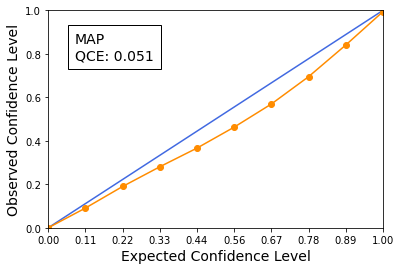

In [3]:
torch.manual_seed(0)

batch_size = 32
dataset = UCIDatasets("power", "./data/", test_percentage=0.2, subsample=1)
trainloader = torch.utils.data.DataLoader(dataset.gap_splits[0][0], batch_size, shuffle=False)
testloader = torch.utils.data.DataLoader(dataset.gap_splits[0][1], batch_size, shuffle=False)
init_var = torch.tensor(0.1).to(device)
def make_res(name, eval_fn, samples):
    return RegressionResults(testloader, name, eval_fn, samples, device, target_mean=1, target_std=1)

layers = [
    ("fc", (dataset.in_dim, 50)),
    ("dropout", (0.1,)),
    ("relu", ()),
    ("fc", (50, 1)),
    ("gauss", (init_var, True))
]
swag = MAP(layers)
swag.train_model(50, nll_loss, adam(0.01), trainloader, batch_size, device, report_every_epochs=5)
swag_res = make_res("MAP", swag.infer, 1000)
print(swag.model[-1].var)

plot_table("Power", [[swag_res]])
plot_calibration("MAP", swag_res, plt.subplot())

In [21]:
from experiments.uci.results import UCIResults
UCIResults("MCD", "power_gap_0", swag_res, 0).store("results.pyc")
print(UCIResults.load("results.pyc").results.qce)

tensor(0.0509)


In [9]:
def eval_on_uci(name, dataset_name, config):
    results = [[] for _ in range(6)]
    for seed in range(5):
        print(f"\n\n================== Seed {seed} ==================")
        torch.manual_seed(seed)
        batch_size = 32
        dataset = UCIDatasets(dataset_name, "./data/", test_percentage=0.2)
        trainloader = torch.utils.data.DataLoader(dataset.train_set, batch_size, shuffle=False)
        testloader = torch.utils.data.DataLoader(dataset.test_set, batch_size, shuffle=False)

        init_var = torch.tensor(0.1).to(device)
        learn_var = True
        layers = [
            ("fc", (dataset.in_dim, 50)),
            ("relu", ()),
            ("fc", (50, 1))
        ]
        def make_res(name, eval_fn, samples):
            return RegressionResults(testloader, name, eval_fn, samples, device, fit_gaussian=False, target_mean=dataset.target_mean, target_std=dataset.target_std)


        print("\n=========== PP training ===========")
        pp = GaussWrapper(PointPredictor(layers), init_var, learn_var)
        pp.train_model(config[0], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        pp_res = make_res("Point Predictor", pp.infer, 1000)
        results[0].append(pp_res)


        print("\n========== SWAG training ==========")
        torch.manual_seed(seed)
        swag_config = {
            "start_epoch": config[1][0],
            "update_every_batches": len(trainloader),
            "deviation_samples": config[1][2]
        }
        swag = GaussWrapper(SwagModel(layers, swag_config), init_var, learn_var)
        swag.train_model(config[1][1], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        swag_res = make_res("SWAG", swag.infer, 1000)
        results[1].append(swag_res)

        print("\n========== SWAG-Diag training ==========")
        torch.manual_seed(seed)
        diag_swag_config = {
            "start_epoch": config[1][0],
            "update_every_batches": len(trainloader),
            "deviation_samples": config[1][2],
            "use_low_rank_cov": False
        }
        diag_swag = GaussWrapper(SwagModel(layers, diag_swag_config), init_var, learn_var)
        diag_swag.train_model(config[1][1], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        diag_swag_res = make_res("SWAG-Diagonal", diag_swag.infer, 1000)
        results[2].append(diag_swag_res)


        print("\n======== Ensemble training ========")
        torch.manual_seed(seed)
        ensemble = Ensemble([GaussWrapper(PointPredictor(layers), init_var, learn_var) for _ in range(5)])
        ensemble.train_model(config[2], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        ensemble_res = make_res("Ensemble-5", ensemble.infer, 1000)
        results[3].append(ensemble_res)


        print("\n======= MC Dropout training =======")
        torch.manual_seed(seed)
        mc_dropout = GaussWrapper(MonteCarloDropoutModule(layers, 0.1), init_var, learn_var)
        mc_dropout.train_model(config[3], sgd(0.01), "mean", trainloader, batch_size, device, report_every_epochs=0)
        mc_res = make_res("Monte Carlo Dropout", mc_dropout.infer, 1000)
        results[4].append(mc_res)


        print("\n=========== BBB training ==========")
        torch.manual_seed(seed)
        bbb_prior = GaussianPrior(0, 1)
        bbb = GaussWrapper(BBBModel(bbb_prior, "activations", layers), init_var, learn_var)
        bbb.train_model(config[4], sgd(lr=0.005), "mean", trainloader, batch_size, device, report_every_epochs=0)
        bbb_res = make_res("Bayes By Backprop", bbb.infer, 1000)
        results[5].append(bbb_res)


    print("\n\n============ Results ============")
    plot_table(name, results, f"results/UCI/{dataset_name}.txt")

    return results

In [10]:
boston_results = eval_on_uci("Boston Housing", "housing", [50, (50, 75, 25), 50, 250, 1000])



================== Seed 0 ==================

=========== PP training ===========
Final loss -0.01912114769220352

========== SWAG training ==========
Final loss -0.021451415494084358
SWAG: Collected 25 out of 25 deviation samples and 25 parameter samples

========== SWAG-Diag training ==========
Final loss -0.021451415494084358
SWAG: Collected 25 out of 25 deviation samples and 25 parameter samples

======== Ensemble training ========
Training ensemble member 0
Final loss -0.018130911514163017
Training ensemble member 1
Final loss -0.01754862442612648
Training ensemble member 2
Final loss -0.018425310030579567
Training ensemble member 3
Final loss -0.019200574606657028
Training ensemble member 4
Final loss -0.01858748495578766

======= MC Dropout training =======
Final loss -0.022725045680999756

=========== BBB training ==========
Final loss 0.5981854200363159


================== Seed 1 ==================

=========== PP training ===========
Final loss -0.021689068526029587

=====

In [19]:
concrete_results = eval_on_uci("Concrete", "concrete", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.02510601095855236
Epoch 100: loss -0.004837113432586193
Final loss -0.00677541783079505

========== SWAG training ==========
Epoch 0: loss 0.023640066385269165
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss -0.004983428865671158
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss -0.0066817160695791245

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.023640066385269165
Epoch 100: loss -0.004983428865671158
Final loss -0.0066817160695791245
Training ensemble member 1
Epoch 0: loss 0.029204111546278
Epoch 100: loss -0.0049481517635285854
Final loss -0.006831923499703407
Training ensemble member 2
Epoch 0: loss 0.02609897591173649
Epoch 100: loss -0.00476755341514945
Final loss -0.00648775277659297
Training ensemble member 3
Epoch 0: loss 0.022709796205163002
Epoch 100: loss -0.005134688690304756
Final loss -0.0066888174042105675
Training 

In [21]:
energy_results = eval_on_uci("Energy", "energy", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.008868275210261345
Epoch 100: loss -0.012672074139118195
Final loss -0.014255918562412262

========== SWAG training ==========
Epoch 0: loss 0.006837711203843355
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss -0.012453894130885601
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss -0.014394803903996944
SWAG: Collected 50 out of 50 deviation samples and 50 parameter samples

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.006837711203843355
Epoch 100: loss -0.012453894130885601
Final loss -0.014394803903996944
Training ensemble member 1
Epoch 0: loss 0.011188078671693802
Epoch 100: loss -0.012472706846892834
Final loss -0.01427349541336298
Training ensemble member 2
Epoch 0: loss 0.01010822132229805
Epoch 100: loss -0.012264619581401348
Final loss -0.014361950568854809
Training ensemble member 3
Epoch 0: loss 0.008416597731411457
Epoch 

In [52]:
power_results = eval_on_uci("Power", "power", [20, (10, 30, 30), 20, 100, 200])



================== Seed 0 ==================

=========== PP training ===========
Final loss -0.0281926691532135

========== SWAG training ==========
Final loss -0.028454666957259178
SWAG: Collected 20 out of 30 deviation samples and 20 parameter samples

======== Ensemble training ========
Training ensemble member 0
Final loss -0.028201373293995857
Training ensemble member 1
Final loss -0.02795032411813736
Training ensemble member 2
Final loss -0.028290176764130592
Training ensemble member 3
Final loss -0.028275756165385246
Training ensemble member 4
Final loss -0.028149623423814774

======= MC Dropout training =======
Final loss -0.026856543496251106

=========== BBB training ==========
Final loss -0.015991250053048134


================== Seed 1 ==================

=========== PP training ===========
Final loss -0.02813655324280262

========== SWAG training ==========
Final loss -0.02831965498626232
SWAG: Collected 20 out of 30 deviation samples and 20 parameter samples

======== 

OSError: [Errno 22] Invalid argument: 'results/UCI/<experiments.uci.UCIDatasets object at 0x0000014C21B03D60>.txt'

In [25]:
wine_results = eval_on_uci("Wine", "wine", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.025987522676587105
Epoch 100: loss 0.002189759397879243
Final loss 0.001964748138561845

========== SWAG training ==========
Epoch 0: loss 0.02562892623245716
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss 0.0021789725869894028
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss 0.001969756791368127
SWAG: Collected 50 out of 50 deviation samples and 50 parameter samples

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.02562892623245716
Epoch 100: loss 0.0021789725869894028
Final loss 0.001969756791368127
Training ensemble member 1
Epoch 0: loss 0.026135500520467758
Epoch 100: loss 0.0020876238122582436
Final loss 0.0018444418674334884
Training ensemble member 2
Epoch 0: loss 0.02367119863629341
Epoch 100: loss 0.002141875447705388
Final loss 0.0019124465761706233
Training ensemble member 3
Epoch 0: loss 0.02484646998345852
Epoch 100: lo

In [27]:
yacht_results = eval_on_uci("Yacht", "yacht", [50, (50, 75, 25), 50, 250, 1000])


=========== PP training ===========
Epoch 0: loss 0.033470556139945984
Epoch 100: loss -0.008822107687592506
Final loss -0.014454040676355362

========== SWAG training ==========
Epoch 0: loss 0.029626406729221344
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Epoch 100: loss -0.008579614572227001
SWAG: Collected 0 out of 50 deviation samples and 0 parameter samples
Final loss -0.013914953917264938
SWAG: Collected 50 out of 50 deviation samples and 50 parameter samples

======== Ensemble training ========
Training ensemble member 0
Epoch 0: loss 0.029626406729221344
Epoch 100: loss -0.008579614572227001
Final loss -0.013914953917264938
Training ensemble member 1
Epoch 0: loss 0.030688820406794548
Epoch 100: loss -0.007360842078924179
Final loss -0.012482451274991035
Training ensemble member 2
Epoch 0: loss 0.030731407925486565
Epoch 100: loss -0.00816725566983223
Final loss -0.013729331083595753
Training ensemble member 3
Epoch 0: loss 0.035993993282318115
Epoch

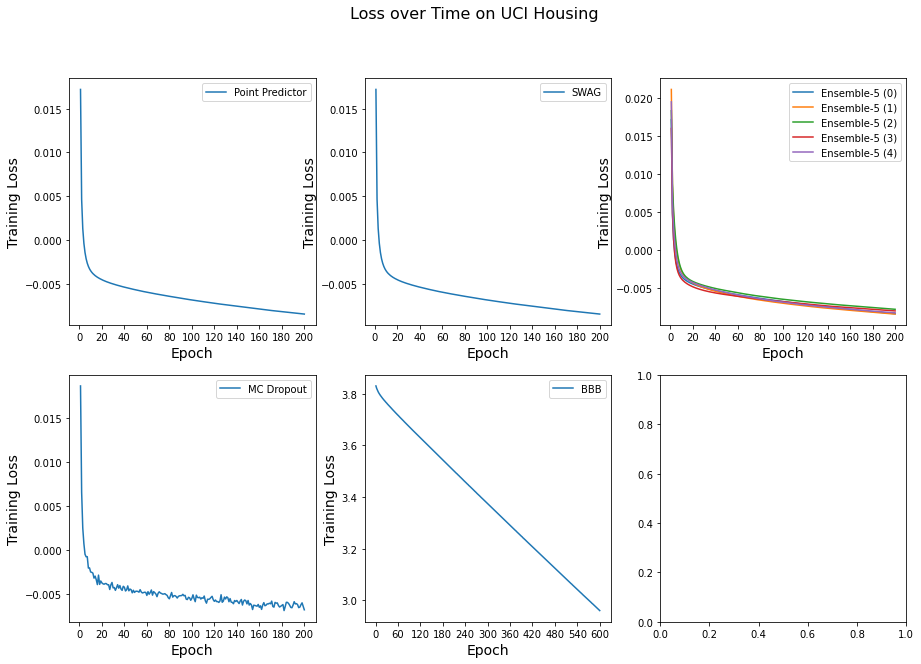

In [232]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Loss over Time on UCI Housing", fontsize=16)
plot_losses("Point Predictor", pp.all_losses(), axes[0,0])
plot_losses("SWAG", swag.all_losses(), axes[0,1])
plot_losses("Ensemble-5", ensemble.all_losses(), axes[0,2])
plot_losses("MC Dropout", mc_dropout.all_losses(), axes[1,0])
plot_losses("BBB", bbb.all_losses(), axes[1,1])

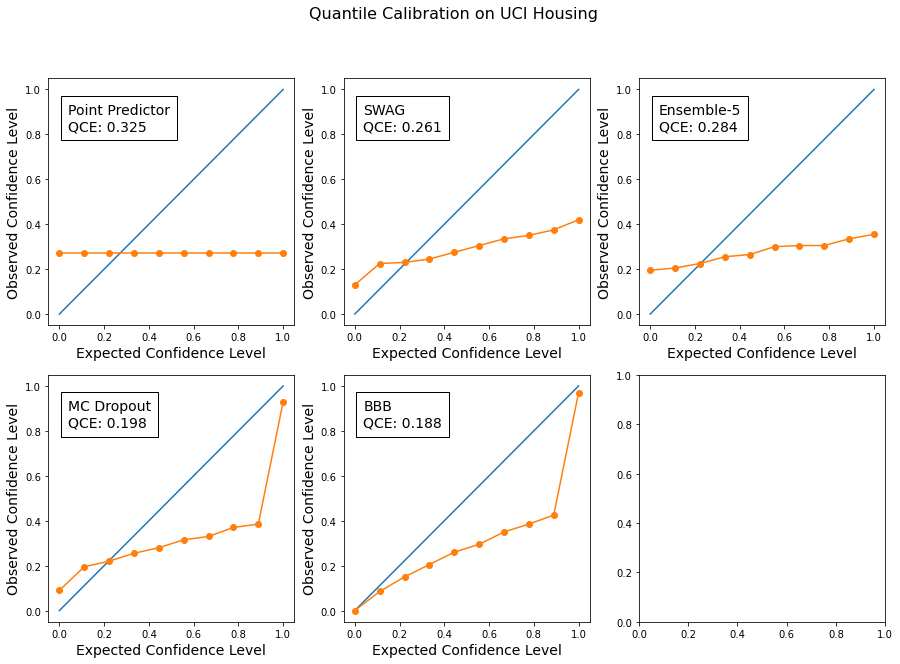

In [233]:
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.suptitle("Quantile Calibration on UCI Housing", fontsize=16)
plot_calibration("Point Predictor", pp_res, axes[0,0])
plot_calibration("SWAG", swag_res, axes[0,1])
plot_calibration("Ensemble-5", ensemble_res, axes[0,2])
plot_calibration("MC Dropout", mc_res, axes[1,0])
plot_calibration("BBB", bbb_res, axes[1,1])

In [235]:
plot_table("Boston Housing", [pp_res, swag_res, ensemble_res, mc_res, bbb_res])

| Boston Housing      |   Avg LML |   Mean MSE |   MSE of Means |   QCE |
|---------------------+-----------+------------+----------------+-------|
| Point Predictor     |    -2.554 |      9.147 |          9.147 | 0.325 |
| SWAG                |    -2.535 |     10.815 |          9.95  | 0.261 |
| Ensemble-5          |    -2.465 |      8.916 |          8.462 | 0.284 |
| Monte Carlo Dropout |    -2.572 |     12.07  |         10.494 | 0.198 |
| Bayes By Backprop   |    -2.904 |     26.164 |         19.179 | 0.188 |
